# 1. Import libraries and data.

In [2]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

# This Sentiment140 dataset contains 1.6mil labelled tweets which we can use for training a sentiment model.
directory = '/Users/alvinyue/Documents/Twitter Sentiment Analysis/Data/'
columns   = ['sentiment', 'id', 'date', 'flag', 'user', 'text']
df_full   = pd.read_csv(directory + 'sentiment140.csv', encoding='latin-1', names=columns)
df_full['sentiment'].replace({4:1}, inplace=True)

df_full

,sentiment,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [24]:
print('Number of Positive Tweets:', len(df_full[df_full['sentiment'] == 1]))
print('Number of Negative Tweets:', len(df_full[df_full['sentiment'] == 0]))

Number of Positive Tweets: 800000
Number of Negative Tweets: 800000


In [3]:
# Prepared by Jovi and Tewan
scrapped_tweets = pd.read_csv('/Users/alvinyue/Documents/CS5344/Final Project/Data/scrapped_tweets.csv')

scrapped_tweets

,account,text,datetime,favourite,retweet,reply_to_user
0,tesla,use tesla phone app to melt snow &amp; ice off...,2021-03-01 18:02:10,97019,11056,NaN
1,tesla,model 3 earns top safety+ award from iihs for ...,2021-02-27 04:47:10,35382,2676,NaN
2,tesla,rt @elonmusk: @austinteslaclub the tesla solar...,2021-02-22 20:23:49,0,2334,NaN
3,tesla,solar roof even clears off the snow,2021-02-21 21:03:24,63125,6286,NaN
4,tesla,plaid winter testing https://t.co/zau1dwzd2u,2021-02-19 20:21:28,27066,1957,NaN
...,...,...,...,...,...,...
12810,VW,jodi has modified all of his #vw cars except f...,2018-10-30 16:09:16,56,8,NaN
12811,VW,@xtianlax great questions! car-net reps are th...,2018-10-29 20:06:49,2,0,9.472472e+17
12812,VW,lost your car in a ramp \nlate because you co...,2018-10-29 15:52:28,34,8,NaN
12813,VW,"@tiocaguama no plans right now, sorry! if anyt...",2018-10-29 13:16:57,1,0,4.098777e+08


# 2. Text preprocessing

In [12]:
nltk_stopwords = stopwords.words('english')
nltk_stopwords.append('amp')
nltk_stopwords.append('quot')
nltk_stopwords.append('u')

# These are the standard preprocessing steps for tweets. Please feel free to add more or edit if necessary.
def text_preprocessing(df):
    lemmatizer = WordNetLemmatizer()
    for index, row in df.iterrows():
        final = ''
        tweet = row['text']
        tweet = re.sub(r'(http)[^ ]*|(www)[^ ]*', 'URL', str(tweet))    # 1. URLs
        tweet = re.sub(r'@[^ ]*', 'mentioneduser', tweet)               # 2. Mentions
        tweet = re.sub(r'[^a-zA-Z0-9]', ' ', tweet)                     # 3. Punctuations
        tweet = re.sub(r'(.)\1\1+', r'\1\1', tweet)                     # 4. Consecutive letters
        tweet = tweet.lower()                                           # 5. Lower case
        tweet = [i for i in tweet.split() if i not in nltk_stopwords]   # 6. Stop word removal
        for i in tweet:
            final += lemmatizer.lemmatize(i) + ' '                      # 7. Lemmatisation
        df.loc[index,'processed_text'] = final
        
    return df

In [22]:
start_time = time.time()

scrapped_tweets_processed = text_preprocessing(scrapped_tweets)

print(f'Time Taken for Text Preprocessing: {round(time.time() - start_time)} seconds')

Time Taken for Text Preprocessing: 19 seconds


In [23]:
scrapped_tweets_processed

,account,text,datetime,favourite,retweet,reply_to_user,processed_text
0,tesla,use tesla phone app to melt snow &amp; ice off...,2021-03-01 18:02:10,97019,11056,NaN,use tesla phone app melt snow ice car even lea...
1,tesla,model 3 earns top safety+ award from iihs for ...,2021-02-27 04:47:10,35382,2676,NaN,model 3 earns top safety award iihs third year...
2,tesla,rt @elonmusk: @austinteslaclub the tesla solar...,2021-02-22 20:23:49,0,2334,NaN,rt mentioneduser mentioneduser tesla solar roo...
3,tesla,solar roof even clears off the snow,2021-02-21 21:03:24,63125,6286,NaN,solar roof even clear snow
4,tesla,plaid winter testing https://t.co/zau1dwzd2u,2021-02-19 20:21:28,27066,1957,NaN,plaid winter testing url
...,...,...,...,...,...,...,...
12810,VW,jodi has modified all of his #vw cars except f...,2018-10-30 16:09:16,56,8,NaN,jodi modified vw car except one alltrack allst...
12811,VW,@xtianlax great questions! car-net reps are th...,2018-10-29 20:06:49,2,0,9.472472e+17,mentioneduser great question car net rep help ...
12812,VW,lost your car in a ramp \nlate because you co...,2018-10-29 15:52:28,34,8,NaN,lost car ramp late find parking never thanks c...
12813,VW,"@tiocaguama no plans right now, sorry! if anyt...",2018-10-29 13:16:57,1,0,4.098777e+08,mentioneduser plan right sorry anything change...


In [16]:
# I've processed 200k out of the 1.6mil tweets before and I'll train using this subset due to limited computing power.
# We might want to explore training on the entire 1.6mil tweets using Spark...
processed_text = pd.read_csv(directory + 'sentiment140_processed_200k.csv')
processed_text = processed_text[processed_text['processed_text'].notna()]

processed_text

,Unnamed: 0,sentiment,id,date,flag,user,text,processed_text
0,1432532,1,2060277909,Sat Jun 06 18:36:12 PDT 2009,NO_QUERY,xftskatie,in a dark stadium &quot;painting&quot; with jo...,dark stadium painting joe jonas wearing faded ...
1,1291931,1,2002953743,Tue Jun 02 05:33:26 PDT 2009,NO_QUERY,VickiLuvzMcFly,bird out though. Now I must check all the dish...,bird though must check dish put finish rest sh...
2,606800,0,2222727615,Thu Jun 18 07:22:01 PDT 2009,NO_QUERY,jedzok,The guitar is still stuck in Morsdorf. I am ge...,guitar still stuck morsdorf getting worried
3,623532,0,2229593814,Thu Jun 18 15:56:19 PDT 2009,NO_QUERY,NuJurzyBoricua,@bronxbebe4488 lol .....nawww that was yesters...,mentioneduser lol naurl yestersday 2 drink ton...
4,296942,0,1997262083,Mon Jun 01 16:32:21 PDT 2009,NO_QUERY,golden86,Very sad to read about A330.,sad read a330
...,...,...,...,...,...,...,...,...
199995,280038,0,1991948234,Mon Jun 01 07:56:38 PDT 2009,NO_QUERY,ohbrandon,"@CynicalCeci dude, we didn't hang on friday",mentioneduser dude hang friday
199996,120429,0,1833134052,Sun May 17 22:23:12 PDT 2009,NO_QUERY,KayleenDuhh,@tishh i agree,mentioneduser agree
199997,427126,0,2063677416,Sun Jun 07 03:38:20 PDT 2009,NO_QUERY,MagicSpud,"@LondonElek thanks man, is there a med school ...",mentioneduser thanks man med school demo inbox...
199998,740466,0,2265998363,Sun Jun 21 07:42:44 PDT 2009,NO_QUERY,tzunihime,loaded with chocolate... note: to much chocola...,loaded chocolate note much chocolate time real...


# 3. Train-test split

In [17]:
# We will train the model using 70% of the data and validate its performance using the remaining 30%.
X = processed_text['processed_text'].tolist()
y = processed_text['sentiment'].tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2020)

print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

139960
139960
59984
59984


# 4. Term frequency-inverse document frequency

In [18]:
# I've used a basic configuration of ngram_range and max_features. Please feel free to edit if necessary.
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=30000)
vectorizer.fit(X_train)

X_train_tfidf = vectorizer.transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(139960, 30000)
(59984, 30000)


# 5. Logistic regression

In [19]:
def model_evaluation(model):
    y_pred = model.predict(X_test_tfidf)
    print('Accuracy on Test Set:', round(model.score(X_test_tfidf, y_test), 3))
    
    cm = confusion_matrix(y_test, y_pred)
    
    categories        = ['Negative', 'Positive']
    group_names       = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_counts      = ['{0:0.0f}'.format(value) for value in cm.flatten()]
    group_percentages = ['{0:.1%}'.format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f'{v1}\n\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,
                annot       = labels,
                annot_kws   = {'size': 16},
                cmap        = 'Blues',
                fmt         = '',
                xticklabels = categories,
                yticklabels = categories)
    
    plt.xlabel('Predicted Sentiments', fontsize=18, fontweight='bold')
    plt.ylabel('Actual Sentiments'   , fontsize=18, fontweight='bold')
    plt.show()

Accuracy on Test Set: 0.771


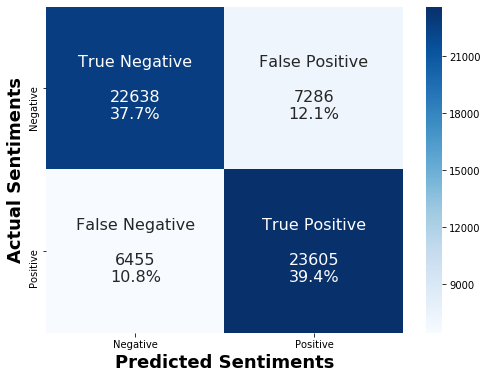

In [20]:
# The results show an accuracy of 77.1% on the test set, i.e. out of every 4 tweets, ~3 are correctly classified.
LR_model = LogisticRegression(max_iter=1000)
LR_model.fit(X_train_tfidf, y_train)
model_evaluation(LR_model)

# 6. Applying on scrapped tweets

In [34]:
def predict_sentiment(vectorizer, model, tweet):
    processed_text = text_preprocessing(tweet)
    processed_text = processed_text['processed_text'].tolist()
    processed_text = vectorizer.transform(processed_text)
    sentiment_pred = model.predict(processed_text)
    
    df = []
    for account, text, prediction in zip(tweet.account.tolist(), tweet.text.tolist(), sentiment_pred):
        df.append((account, text, prediction))
    df = pd.DataFrame(df, columns = ['account', 'text', 'sentiment'])
    df = df.replace([0,1], ['Negative', 'Positive'])
    
    return df

In [35]:
scrapped_tweets_sentiments = predict_sentiment(vectorizer, LR_model, scrapped_tweets)

scrapped_tweets_sentiments

,account,text,sentiment
0,tesla,use tesla phone app to melt snow &amp; ice off...,Negative
1,tesla,model 3 earns top safety+ award from iihs for ...,Positive
2,tesla,rt @elonmusk: @austinteslaclub the tesla solar...,Positive
3,tesla,solar roof even clears off the snow,Positive
4,tesla,plaid winter testing https://t.co/zau1dwzd2u,Positive
...,...,...,...
12810,VW,jodi has modified all of his #vw cars except f...,Negative
12811,VW,@xtianlax great questions! car-net reps are th...,Positive
12812,VW,lost your car in a ramp \nlate because you co...,Negative
12813,VW,"@tiocaguama no plans right now, sorry! if anyt...",Positive


In [36]:
# Most of the tweets seem to be positive.
# We can vary the probability threshold from the current 0.5 to output negative, neutral and positive if necessary.
scrapped_tweets_sentiments.groupby(['account', 'sentiment']).size()

account  sentiment
VW       Negative      585
         Positive     2618
hyundai  Negative      245
         Positive     2959
kia      Negative      680
         Positive     2533
tesla    Negative      486
         Positive     2709
dtype: int64

# 7. Word Cloud

In [37]:
scrapped_tweets_sentiments = text_preprocessing(scrapped_tweets_sentiments)

scrapped_tweets_sentiments

,account,text,sentiment,processed_text
0,tesla,use tesla phone app to melt snow &amp; ice off...,Negative,use tesla phone app melt snow ice car even lea...
1,tesla,model 3 earns top safety+ award from iihs for ...,Positive,model 3 earns top safety award iihs third year...
2,tesla,rt @elonmusk: @austinteslaclub the tesla solar...,Positive,rt mentioneduser mentioneduser tesla solar roo...
3,tesla,solar roof even clears off the snow,Positive,solar roof even clear snow
4,tesla,plaid winter testing https://t.co/zau1dwzd2u,Positive,plaid winter testing url
...,...,...,...,...
12810,VW,jodi has modified all of his #vw cars except f...,Negative,jodi modified vw car except one alltrack allst...
12811,VW,@xtianlax great questions! car-net reps are th...,Positive,mentioneduser great question car net rep help ...
12812,VW,lost your car in a ramp \nlate because you co...,Negative,lost car ramp late find parking never thanks c...
12813,VW,"@tiocaguama no plans right now, sorry! if anyt...",Positive,mentioneduser plan right sorry anything change...


In [39]:
positive_tweets = scrapped_tweets_sentiments[scrapped_tweets_sentiments['sentiment'] == 'Positive']['processed_text'].tolist()
negative_tweets = scrapped_tweets_sentiments[scrapped_tweets_sentiments['sentiment'] == 'Negative']['processed_text'].tolist()

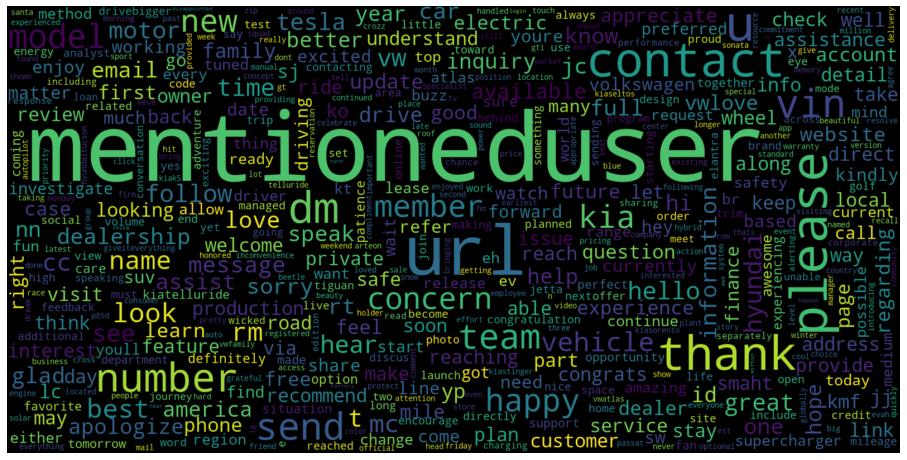

In [40]:
# Positive word cloud
plt.figure(figsize = (16,16))
positive_wc = WordCloud(max_words        = 500,
                        width            = 1600,
                        height           = 800,
                        background_color = 'black',
                        collocations     = False).generate(' '.join(positive_tweets))
plt.imshow(positive_wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()

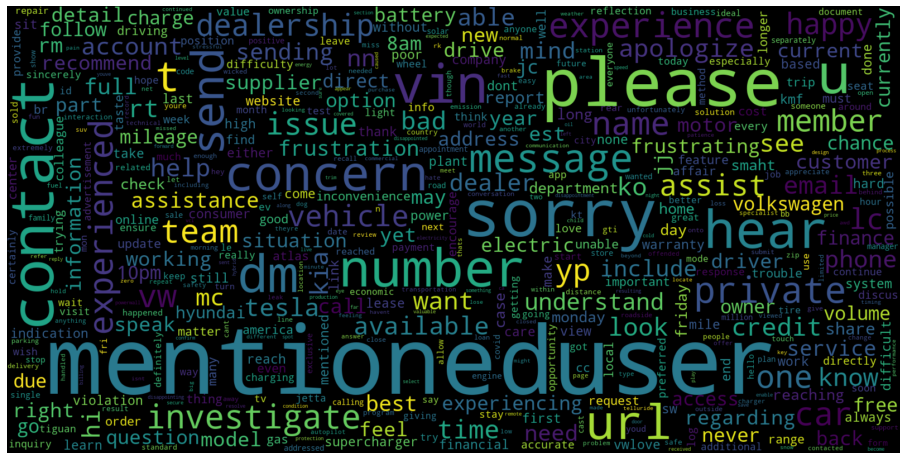

In [41]:
# Negative word cloud
plt.figure(figsize = (16,16))
negative_wc = WordCloud(max_words        = 500,
                        width            = 1600,
                        height           = 800,
                        background_color = 'black',
                        collocations     = False).generate(' '.join(negative_tweets))
plt.imshow(negative_wc, interpolation = 'bilinear')
plt.axis('off')
plt.show()